# Segment Anything Model (SAM) by Facebook

## To fasten the masking process and improve the user experience (UX) while masking the objects in an image while performing Image Editing.
### 1. This process requires the user to just click on the intended object he/she wishes to replace/remove/fill
### 2. The SAM model will pick the point co-ordinate and tries to identify the object and sequentially fills a mask around the object
### 3. This is helpful to the end users as they are not supposed to spend more time in creating mask with pixel accuracy

!(segment-anything)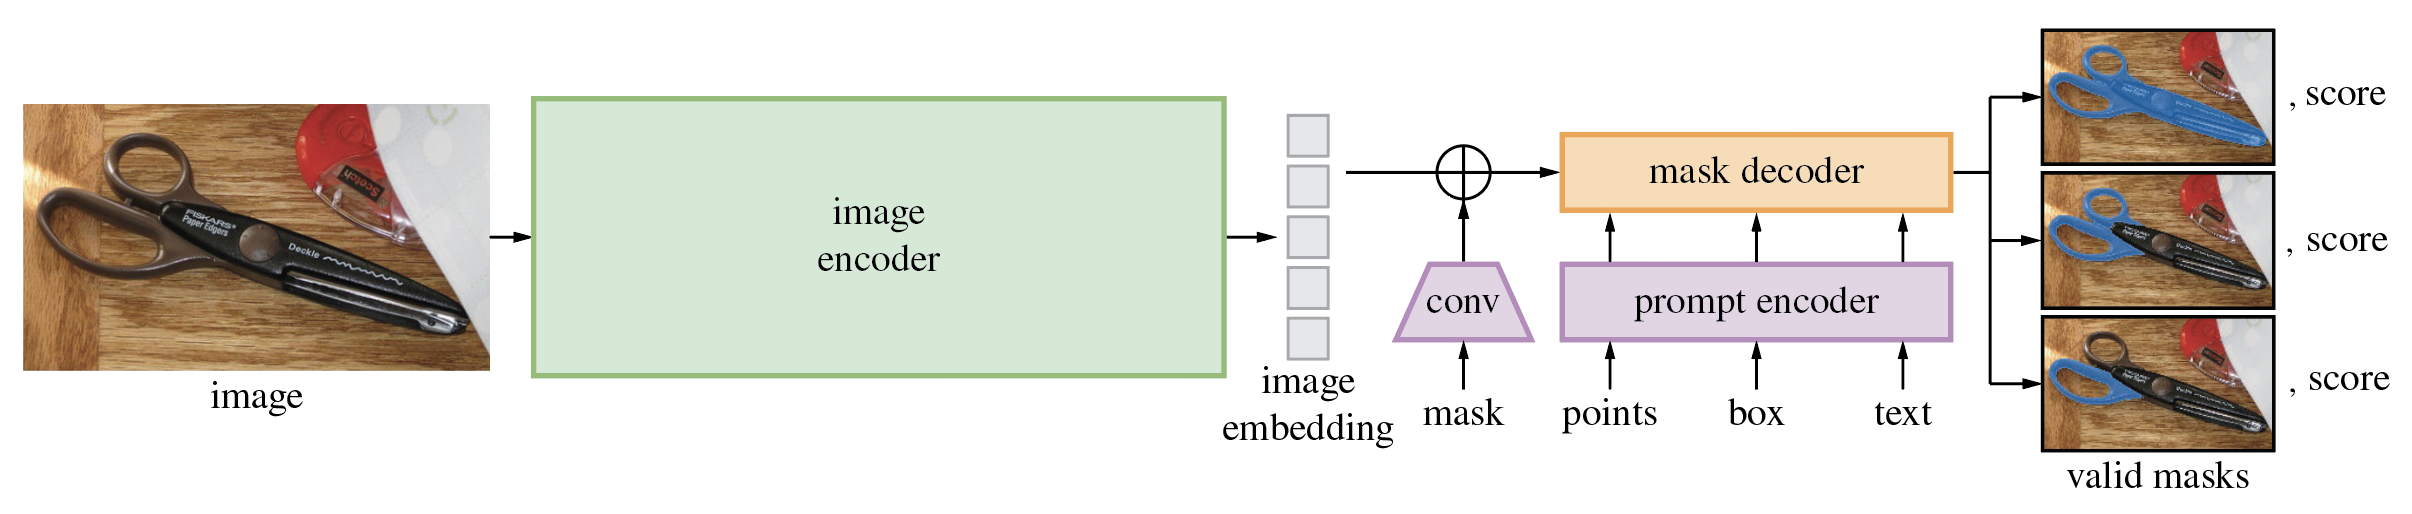

### Installation of packages

In [ ]:
# !pip install git+https://github.com/facebookresearch/segment-anything.git

In [2]:
import cv2
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry

In [3]:
def load_model(model_type, checkpoint, device):
    """Loads the SAM model into GPU memory"""
    model_sam = sam_model_registry[model_type](checkpoint=checkpoint)
    model_sam.to(device=device)
    model = SamPredictor(model_sam)
    return model


def prepare_image(image_path):
    """Prepares the image by resizing it and converting to RGB"""
    img = cv2.imread(image_path)
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

    
def sam_create_masks(image_path, point, model):
    """Creates binary masks for an image given the clicked point co-ordinate by the user"""
    img = prepare_image(image_path)
    
    model.set_image(img)
    masks, _, _ = model.predict(point_coords=np.array([point]), point_labels=np.array([1]), multimask_output=True)
    
    binary_masks = []
    for idx, mask in enumerate(masks):
        binary_mask = Image.fromarray(masks[idx])
        binary_masks.append(binary_mask)
    return binary_masks


def masked_pil_image(binary_mask, image):
    """Takes original image and binary mask as input and embeds the mask on top of original image"""
    numpy_binary = np.array(binary_mask)
    numpy_binary = numpy_binary.astype(np.uint8)

    dummy_ones = np.ones((image.shape[0], image.shape[1]), dtype=np.float32)
    mask_invert = dummy_ones - numpy_binary
    mask_invert = mask_invert.astype(np.uint8)

    h = np.expand_dims(mask_invert, axis=-1)
    masked_image = image*h
    a = masked_image.astype(np.uint8)
    masked_image_pil = Image.fromarray(a)
    return masked_image_pil

In [4]:
point = [233, 311]
image_path = "inpainting_dataset/images/10.png"

image = prepare_image(image_path)

model = load_model(model_type="vit_h", checkpoint="sam_vit_h_4b8939.pth", device="cuda")

b_masks = sam_create_masks(image_path, point, model)

masked_image = masked_pil_image(b_masks[-1], image)

### Create binary masks for the pointed co-ordinate

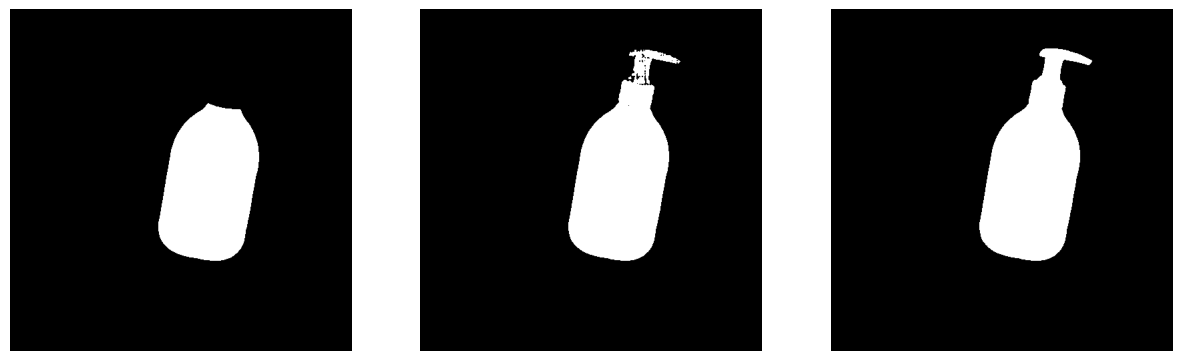

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

for mask, ax in zip(b_masks, axs.ravel()):
    ax.imshow(mask)
    ax.axis("off")
    ax.set_xlabel("")

plt.show()

### Choose the best binary mask and place it on the original image

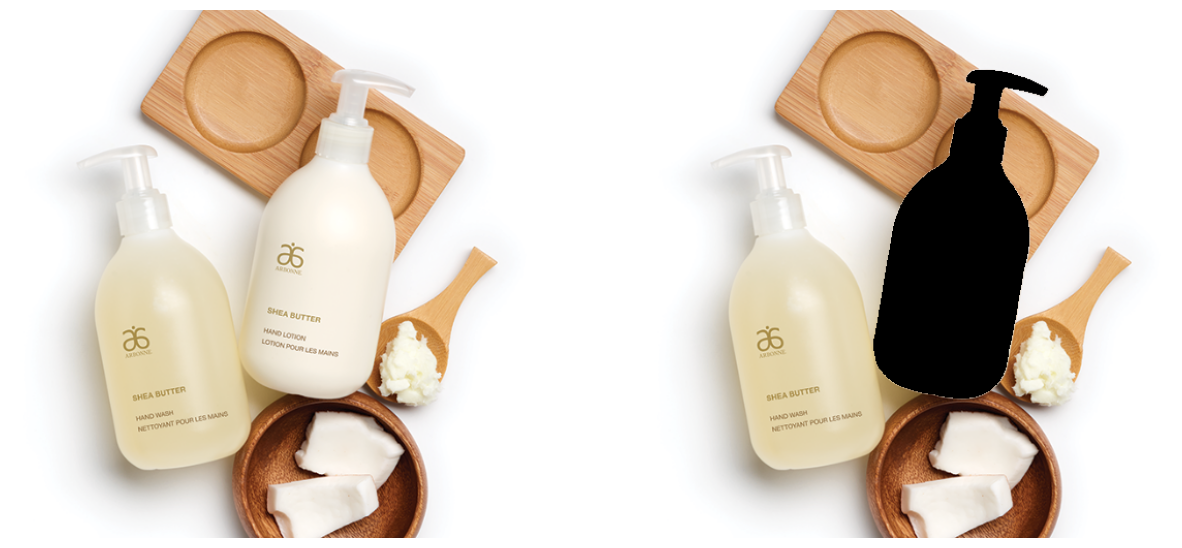

In [6]:
images = [image, masked_image]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

for image, ax in zip(images, axs.ravel()):
    ax.imshow(image)
    ax.axis("off")
    ax.set_xlabel("")

plt.show()